#Tweet sentiment Classification

This notebook will be able to classify airline tweets as positive, neutral, or negative using a pre-trained word model - ULMFiT -  and a RNN. ULMFiT is a transfer learning method developed by Fast AI that can be applied to any task in NLP.


Dataset:
https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv

Libraries:

*   https://docs.fast.ai/
*   https://pytorch.org/

The structure of this notebook is the following:

1.   Data Analysis and data formatting:  I explain the process of extracting the information from the cvs file and the process of convert the data in to a ' trainable ' format
2.   Training the language learner model: I create the model and train it - applying tranfer learning - in order to achieve a valid accuracy (  30% approx)
3.   Training the classification learner: Using the trained language learne, I create a classification model which achive 80% accuracy in the classification task
4.    Results analysis
5.    Conclusions



##0. Set-up: Mounting Gdrive , importing the Fast AI library and setting the working directory

In [0]:
# Ejecuta esta celda para activar tu cuenta de Google Drive.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from fastai.text import *

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
path=Path('/content/gdrive/My Drive/Colab Notebooks/Fellowship/twitter')

## 1. Data analysis and data formatting

About the data set:

*   The dataset is called “Twitter US Airline Sentiment” which was downloaded from Kaggle as a csv file. 
*   The tweets has been classified as either “positive”, “neutral”, or “negative” and confidence score for the assigned label. For the negative classification, the reason is mentioned in the file






### 1.1.- Loading the data

Load the file and extract the columns

In [0]:
tweet = pd.read_csv(path/'Tweets.csv')


In [0]:
tweet.head(3) # The data set looks like this:

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


The dataset is not perfectly balanced. From now, I will leave as it is but if the classification model doesn't perform as expected. I will balance it.

In [0]:
print('Number of tweets per sentiment:\n',tweet.airline_sentiment.value_counts())
print('\n')
print('Normalized number of tweets per sentiment:\n',tweet.airline_sentiment.value_counts(normalize=True))

Number of tweets per sentiment:
 negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


Normalized number of tweets per sentiment:
 negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64


for this analysis, only the tweet and the sentiment classification matters, so I create a data_df panda with only these 3 columns.

In [0]:
data_df=tweet[['text','airline_sentiment','airline_sentiment_confidence']] 

In [0]:
data_df.head()

,text,airline_sentiment,airline_sentiment_confidence
0,@VirginAmerica What @dhepburn said.,neutral,1.0000
1,@VirginAmerica plus you've added commercials t...,positive,0.3486
2,@VirginAmerica I didn't today... Must mean I n...,neutral,0.6837
3,@VirginAmerica it's really aggressive to blast...,negative,1.0000
4,@VirginAmerica and it's a really big bad thing...,negative,1.0000


In [0]:
data_df.to_csv(path/'texts.csv',index=False) # I save the panda.

In [0]:
data_df=pd.read_csv(path/"texts.csv") # I load the panda

### 1.2.- Formatting the data for the model

In order to train a model using the data we need to convert it in a format the the model can understand and train and it is done using the TextList class.What this class does is:


*   Tokenization: Creates a separate unit (i.e. a “token”) for each separate part of a word and save each of these 'tokens' in a dictionary ( aka vocabulary)
*   Numericalization: Converts each token in a integrer so the model can process them.

In [0]:
bs=256

In [0]:
data_lm = (TextList.from_csv(path, 'texts.csv', cols='text')  # Where is the data, which file and column.
            .split_by_rand_pct(0.2) # We split the dataset between train and validation ( 20% )
            .label_for_lm()        # Special command for NLP learner   
            .databunch(bs=bs))     # batch size
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:
# Here I am plotting the different steps carried out by the Text list class.
print('Original Text:')
print(data_df.iloc[1,1])
print('\n')
print('Tokenized text:')
print(data_lm.train_ds[0][0])
print('\n')
print('Numerical text:')
print(data_lm.train_ds[0][0].data[:10])

Original Text:
@VirginAmerica plus you've added commercials to the experience... tacky.


Tokenized text:
xxbos @virginamerica plus you 've added commercials to the experience ... xxunk .


Numerical text:
[   2  105  599   17  114 1135 2787   10   12  221]


In [0]:
# These are the 20 most frequent token that appear in the dictionary.
# All the tokens starting with xx ( i.e. xxunk,xxpad,...) are special tokens which describe the format of the text

data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'to',
 'i',
 'the',
 '!',
 'a',
 '?',
 '/',
 'you',
 ',',
 'for']

These are the most frequent words ( without special characters and which length is >4  )

In [0]:
voc=[]
voc = [item for item in data_lm.vocab.itos if ('xx' not in item) and (len(item)>4)]
voc[:20]

['flight',
 '@united',
 '@usairways',
 '@americanair',
 '@southwestair',
 '@jetblue',
 'cancelled',
 'thanks',
 'service',
 'customer',
 'hours',
 'flights',
 'there',
 'plane',
 'thank',
 'would',
 'still',
 'please',
 'delayed',
 'flightled']

## 2. Training the language model using AWD_LSTM.

Now we can create the learner. In this case we are using the 'language_model_learner' which creates  a RNN (recurrent neural network).

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
learn.summary() #This is the architecture of the language model learner

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 4080]           1,636,080  True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 1,636,080
Total trainable params: 1,636,080
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss func

In order to train the model I am going to follow this process:



*   Identify the best initial learning rate using lr_find(). It plots lr vs loss relationship for a learner so I can choose the best starting lr
*   Plot the learning rate.
*   Train the model using the fit_one_cycle based on Leslie Smith's 1cycle policy.
*   Save the model 


### 1 round: 1 epoch & lr = 1e-2

In [0]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


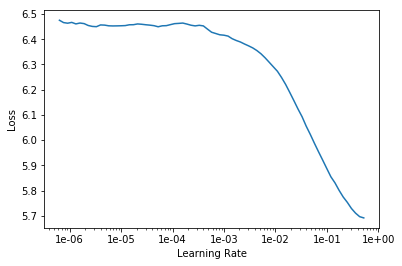

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.553205,4.873003,0.200056,00:18


In [0]:
learn.save('tweet_1_cycle')

In [0]:
learn.load('tweet_1_cycle');

### 2 round: 10 epoch and lr: 1e-3

In [0]:
learn.fit_one_cycle(10, 1e-3)
learn.save('tweet_10_cycle')

epoch,train_loss,valid_loss,accuracy,time
0,4.934788,4.852840,0.200474,00:18
1,4.904218,4.766737,0.203850,00:18
2,4.839352,4.626996,0.209780,00:17
3,4.755868,4.499255,0.214802,00:18
4,4.664332,4.399631,0.220773,00:17
5,4.579199,4.330450,0.223898,00:18
6,4.508368,4.282147,0.225837,00:17
7,4.445081,4.256401,0.226018,00:18
8,4.395432,4.244517,0.226702,00:18
9,4.358726,4.244060,0.226158,00:18


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


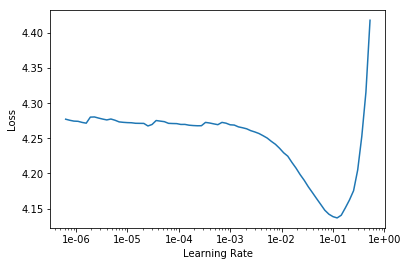

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

### round 3: Unfreeze the model. 10 epoch & lr: 1e-3

So far I have been only training the latest layers of the model. After calling learn.unfreeze( ) I am allowing the model to train the whole architecture.

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)
learn.save('tweet_10_cycl-unfreeze')


epoch,train_loss,valid_loss,accuracy,time
0,4.119964,3.962147,0.254297,00:24
1,3.979422,3.820221,0.272224,00:24
2,3.864680,3.731414,0.284807,00:24
3,3.750980,3.682447,0.289955,00:24
4,3.641488,3.656018,0.293150,00:24
5,3.530940,3.645060,0.294280,00:24
6,3.462245,3.666821,0.287779,00:24
7,3.369169,3.662431,0.293973,00:24
8,3.289595,3.665033,0.293025,00:24
9,3.228258,3.666741,0.293094,00:24


### round 4: Unfreeze the model. 10 epoch & lr: 1e-3

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


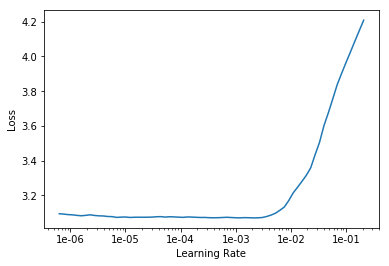

In [0]:

learn.load('tweet_10_cycl-unfreeze')
learn.lr_find()
learn.recorder.plot(skip_end=15)


In [0]:
# I reduce the lr by one order of magnitude
learn.fit_one_cycle(5, 1e-4)


epoch,train_loss,valid_loss,accuracy,time
0,3.066545,3.668571,0.293108,00:24
1,3.061672,3.669597,0.292411,00:24
2,3.054760,3.671178,0.292857,00:24
3,3.042768,3.672204,0.293094,00:24
4,3.039199,3.673077,0.292815,00:24


In [0]:
learn.save('tweet_10_cycl-unfreeze-e5')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


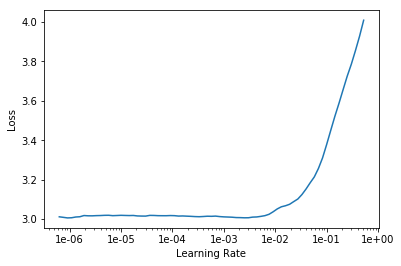

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=15)


### round 5: Unfreeze the model. 5 epochs & lr: 1e-4

In [0]:
# 5 more epochs
learn.load('tweet_10_cycl-unfreeze-e5')
learn.fit_one_cycle(5, 1e-4)


epoch,train_loss,valid_loss,accuracy,time
0,3.023742,3.673779,0.293178,00:24
1,3.031167,3.674665,0.293025,00:24
2,3.030450,3.673790,0.293555,00:24
3,3.012726,3.677912,0.292773,00:24
4,3.012006,3.676847,0.293108,00:24


### Stop training

The accuracy of the language model is 30% which it is enough for our sentiment classification purpose.
The language model is designed to generate ( or predict ) the next item of a sequence -  words in this case - which as mentioned is not really the purpose of this notebook.  For this reason, I consider that 30% accuracy is enough so I save the encoder.

The encoder is the part of the model which ' understand ' the sentence. I will load the encoder in the next section ( Classification )

In [0]:
# I consider that 30% accuracy is enough. I save the model and the encoder
learn.save('tweet_10_cycl-unfreeze-e10')


In [0]:
learn.save_encoder('enc_tweet_10_cycl-unfreeze-e10')

In any case, I can use the predictions of the learner to write some tweets. 

In [0]:
learn.load('tweet_10_cycl-unfreeze-e10');



In [0]:
# Just for fun I ask the model to write 2 tweets
TEXT = "I have lost "
N_WORDS = 20
tweets = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(tweets)))

I have lost  my bags and i ca n't find a flight that has been Cancelled Flightled , we are leaving
I have lost  my family my miles , but i have a few sense of humor xxbos @jetblue Why does this line


## 3. Training the classification model

### data and model creation

Now I create the data_clas object which I will use to build a classifier with our fine-tuned encoder. The method to create the object is similar to the one showed before.

We include the data_lm.vocab used for the language training model

In [0]:
# I create the data for the classification model.
# Sentiment label is in the column 2
data_clas = (TextList.from_csv(path, 'texts.csv', cols='text',vocab=data_lm.vocab)
            .split_by_rand_pct(0.2)
           #I randomly split and keep 20% for validation
            .label_from_df(cols=2)           
            .databunch(bs=256))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=256)

In [0]:
data_clas.show_batch() # This is how the data looks like and the target ( sentiment )

text,target
xxbos @united xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,negative
"xxbos @usairways e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",positive
"xxbos @usairways 4 xxunk , 4 / 4 delayed . xxmaj xxunk > xxup ctl . xxup ctl > xxup jan . xxup jan > xxup ctl . xxup ctl > xxup xxunk . xxmaj my year off from flying with you guys was the way to go .",negative
"xxbos @americanair our ft xxunk xxup xxunk / xxup dfw ( w / cx to xxup lga ) tomorrow xxmaj cancelled xxmaj flighted , 4 hrs so far waiting for call back . xxmaj what should we do ? xxmaj need to get to nyc",negative
"xxbos @americanair xxmaj hey , xxup aa ! xxmaj there was a mistake made by your xxup cr on my xxmaj flight xxmaj booking xxmaj problems . xxmaj when i call your reservations # , i keep getting hung up on . xxmaj advise .",negative


This time, rather than creating a language model learner, we’re creating a text classifier learner.
I include the encoder generated in the previous language model training.

In [0]:
# Create the learner and load the encoder
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('enc_tweet_10_cycl-unfreeze-e10')

In [0]:
# and this is its architecture of the classification model
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [53, 400]            0          False     
______________________________________________________________________
RNNDropout           [53, 1152]           0          False     
______________________________________________________________________
RNNDropout           [53, 1152]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
________________________________________________

For the training of the classification model I will use the same process described before:

*   Identify the best initial learning rate using lr_find(). It plots lr vs loss relationship for a learner so I can choose the best starting lr
*   Plot the learning rate.
*   Train the model using the fit_one_cycle based on Leslie Smith's 1cycle policy.
*   Save the model 

### Round 1: 1 epoch and lr: 1e-2

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


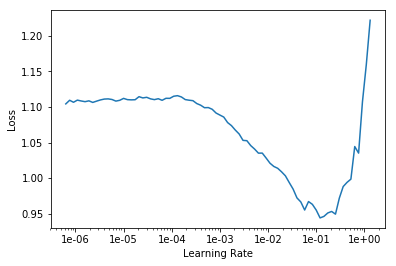

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.791217,0.588389,0.765710,00:09
1,0.699029,0.539872,0.783470,00:09
2,0.657660,0.521913,0.791667,00:09


In [0]:
learn.save('3-cycle-class')


In [0]:
learn.load('3-cycle-class');

### Round 2: 1 epoch, discriminative learning rates and discriminative layer training

**discriminative learning rates.**
I apply different learning rates to different group of layers.

**Discriminative layer training**
Instead of unfreezing the whole model, I am just goint to unfreeze the last 2 groups of layers as it seems to be benefitial for classification models.

**momentum**
 For training RNN, slowing the momentum it is a good technique as it seems to accelerate the training.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 3.31E-07


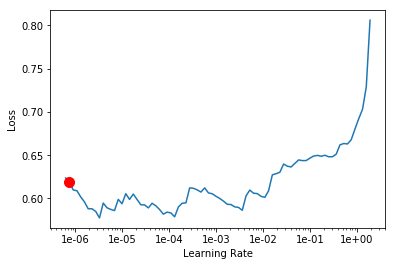

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.608015,0.554241,0.776298,00:11
1,0.611125,0.513321,0.800205,00:10
2,0.577608,0.493403,0.799863,00:11


In [0]:
learn.save('3-cycle-class-round2')

### Round 3: 2 epochs, lower discriminative learning rates and highrt number of discriminative layer training

In [0]:
learn.load('3-cycle-class-round2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 9.12E-08


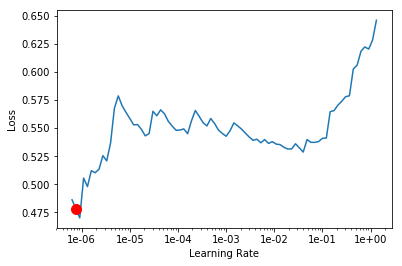

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(1e-4/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.549752,0.480020,0.811475,00:18
1,0.549999,0.516546,0.798839,00:17
2,0.537982,0.472321,0.816940,00:17


In [0]:
learn.save('3-cycle-class-round3')

In [0]:
learn.load('3-cycle-class-round3');

## 4. Result Analysis


### Individual predictions

Once the model has fininsh, I can validate the model.The following 4 lines are 4 different predictions

In [0]:
learn.predict("@united thank you. I flew into Newark from Vail/Eagle.")


(Category positive, tensor(2), tensor([0.0449, 0.2877, 0.6674]))

In [0]:
learn.predict("@united where's my damn bag??")


(Category negative, tensor(0), tensor([0.6774, 0.2834, 0.0392]))

In [0]:
learn.predict("@united I would love if someone could get me back to Austin tonight and I do not wish to wait til tomorrow morning.")


(Category negative, tensor(0), tensor([0.5471, 0.4043, 0.0487]))

In [0]:
learn.predict("@united please upload the March on-demand entertainment listing on your website! âœˆï¸")




(Category negative, tensor(0), tensor([0.5054, 0.2351, 0.2594]))

###Validation set

Using the function ' interp' I can plot the confusion matrix of the model. As we can see, the most missclassified tweets are the neutral ones. 


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

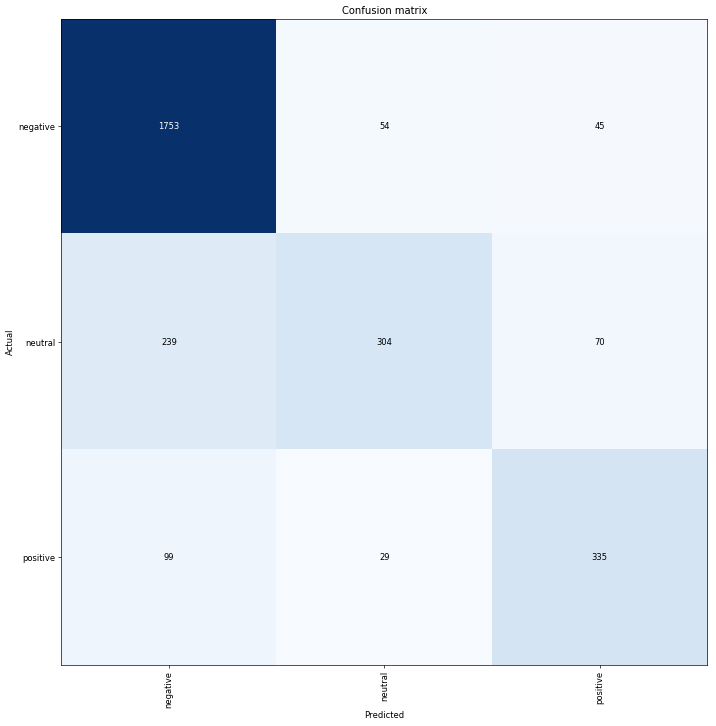

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Full dataset predictions

Now I predict the sentiment of all the dataset.

In [0]:
sentiment=[]
for index, row in data_df.iterrows():    
    tweet=row['text']
    pred=learn.predict(tweet)
    idx=pred[1]
    idx=idx.item()
    p=pred[2][idx].item()
    sentiment.append([tweet,pred[0],"{:10.2f}".format(p)])
    

In [0]:
# Save as Panda and as CSV.

df_sentiment = pd.DataFrame(sentiment,columns =['tweet', 'sentiment','prob']) 
#df.to_csv(path/"tweets_submission.csv", index=False)
df_sentiment.to_csv(path/"tweets_sent_classification.csv", index=False)

In [0]:
df_sentiment=pd.read_csv(path/'tweets_sent_classification.csv')

As shown in the classification matrix, most of the missclassified tweets are the neutral tweets classified as negative

In [0]:
# My prediction
print(df_sentiment.sentiment.value_counts(normalize=True))

negative    0.706489
positive    0.155055
neutral     0.138456
Name: sentiment, dtype: float64


In [0]:
# Original file. 
original = pd.read_csv(path/'Tweets.csv')
print(original.airline_sentiment.value_counts(normalize=True))

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64


### Analysis

In this section I will tryto find the reason for this missclassification

In [0]:
data_df=data_df[['airline_sentiment','airline_sentiment_confidence']] 

In [0]:
# I combine both the prediction and the ground truth

model_vs_real =pd.concat([df_sentiment,data_df], axis=1)

In [0]:
# The columns 2nd and 3rd are the predictions from the model ( sentiment and probability)
# Columns 4th and 5th are the labels provided in the dataset
print('The number of tweets in the data set are:',model_vs_real.tweet.count()) 
model_vs_real.head()

The number of tweets in the data set are: 14640


,tweet,sentiment,prob,airline_sentiment,airline_sentiment_confidence
0,@VirginAmerica What @dhepburn said.,negative,0.53,neutral,1.0000
1,@VirginAmerica plus you've added commercials t...,negative,0.57,positive,0.3486
2,@VirginAmerica I didn't today... Must mean I n...,negative,0.58,neutral,0.6837
3,@VirginAmerica it's really aggressive to blast...,negative,0.97,negative,1.0000
4,@VirginAmerica and it's a really big bad thing...,negative,0.84,negative,1.0000


In [0]:
# I compare the prediction Vs the truth and I extract the ones where there's a difference in order to analyse.

analysis=[]

for index, row in model_vs_real.iterrows():
    if (row['sentiment'] != row['airline_sentiment']):
      analysis.append([index,row['tweet'],row['sentiment'],row['prob'],row['airline_sentiment'],row['airline_sentiment_confidence']])

In [0]:
analysis_pd = pd.DataFrame(analysis,columns =['index','tweet', 'sentiment','prob','true_sent','sent_conf']) 
analysis_pd.to_csv(path/"analysis_tweets_sent_classification.csv", index=False)


These are the missclassified tweets in the dataset

In [0]:
# These are tweets where the model and the dataset sentiment don't match
analysis_pd=pd.read_csv(path/'analysis_tweets_sent_classification.csv')
print('The number of misclassified tweets are:',analysis_pd.tweet.count()) 
analysis_pd.head()

The number of misclassified tweets are: 2286


,index,tweet,sentiment,prob,true_sent,sent_conf
0,0,@VirginAmerica What @dhepburn said.,negative,0.53,neutral,1.0000
1,1,@VirginAmerica plus you've added commercials t...,negative,0.57,positive,0.3486
2,2,@VirginAmerica I didn't today... Must mean I n...,negative,0.58,neutral,0.6837
3,6,"@VirginAmerica yes, nearly every time I fly VX...",negative,0.62,positive,0.6745
4,7,@VirginAmerica Really missed a prime opportuni...,negative,0.89,neutral,0.6340


As mention in the introduction, the sentiment of the dataset has confidence score for the assigned label. 

Below I am showing the tweets where the model predict the label with high confidence ( prob > 0.95) but the confidence score is below 0.5. as we can see, there are some tweets incorrectly labelled in the data set. For example, the tweet '@SouthwestAir thanks!!' is labelled as neutral when it is clearly a positive tweet'




In [0]:
analysis_pd[(analysis_pd['prob']>0.95)&(analysis_pd['sent_conf']<0.5)]

,index,tweet,sentiment,prob,true_sent,sent_conf
761,4650,@SouthwestAir thanks!!,positive,0.98,neutral,0.3591
1364,7902,@JetBlue thanks anyways @SouthwestAir has my b...,positive,0.98,neutral,0.3602
1831,11184,@USAirways if you've got room on an earlier fl...,negative,0.97,neutral,0.3511


In [0]:
# This is a print of the tweets mentioned above
analysis_pd[(analysis_pd['prob']>0.95)&(analysis_pd['sent_conf']<0.5)].tweet.tolist()

['@SouthwestAir thanks!!',
 '@JetBlue thanks anyways @SouthwestAir has my back! Awesome rate &amp; amazing customer service #nomoreaggravation',
 "@USAirways if you've got room on an earlier flight home, why charge me $75 to get on it? Be the hero!"]

The issue mentioned above appears as well in high confidence scored labels ( >0.8) where the sentiment predicted by the model makes more sense that the label provided in the dataset.

In [0]:
analysis_pd[(analysis_pd['prob']>0.95)&(analysis_pd['sent_conf']>0.8)][:10]

,index,tweet,sentiment,prob,true_sent,sent_conf
340,2003,"@united I tried. We were hung up on, twice. ...",negative,0.99,neutral,1.0
538,3380,@united still waiting for a response on whethe...,negative,0.97,neutral,1.0
628,3862,@united thanks for reaching out. The seat was ...,positive,0.96,negative,1.0
699,4343,@SouthwestAir I have been on hold for over 28 ...,negative,0.96,neutral,1.0
887,5529,@SouthwestAir OMG OMG OMG !!! I JUST DID!!,positive,0.98,neutral,1.0
1583,8971,@USAirways never received such horrible servic...,negative,1.00,neutral,1.0
1584,8975,@USAirways agree! Richard P. Literally ripped ...,negative,0.99,neutral,1.0
1595,9026,@USAirways and now you can't even accommodate ...,negative,0.99,neutral,1.0
1596,9031,@USAirways 2 calls &amp; wasted 3 hrs on hold...,negative,0.97,neutral,1.0
1611,9110,@USAirways &amp; @AmericanAir: 1 flight Cancel...,negative,0.97,neutral,1.0


In [0]:
analysis_pd[(analysis_pd['prob']>0.95)&(analysis_pd['sent_conf']>0.8)][:10].tweet.tolist()

['@united I tried.   We were hung up on, twice. After speaking with someone, then put on hold for 45 minutes.  No resolution.',
 '@united still waiting for a response on whether or not you allow use of a rear facing car seat on an ERJ145.',
 '@united thanks for reaching out. The seat was hard, not enough cushion. OK for short flight. BTW, UA6465 flight and crew were great!',
 '@SouthwestAir I have been on hold for over 28 minutes  please help http://t.co/Fx9BIJlxAt',
 '@SouthwestAir OMG OMG OMG !!! I JUST DID!!',
 '@USAirways never received such horrible service or treated so poorly as Richard P. today. No excuse for attitude &amp; ripping up our tickets!',
 '@USAirways agree! Richard P. Literally ripped up our tixs in our faces and made rude, inappropriate comments to us and our family. Awful!',
 "@USAirways and now you can't even accommodate us by letting us fly in to another airport?! Horrible service for your fault!!!",
 "@USAirways  2 calls &amp; wasted 3 hrs on hold to change my 

## 5.Conclusion

I can conclude that the classification model works pretty well for this dataset even the dataset is not perfectly balanced and some labels are incorrect. As shown in the result analysis, when the model has a high confidence, it is likely to predict the right sentiment.

with regards the accuracy of the model, I could improve it by skiping the tweets which have low confidence score for the assigned label.



In [0]:
freq_prob=analysis_pd['prob'].values.tolist()


In [0]:
def CountFrequency(test_list): 
  
    # Creating an empty dictionary  
    freq_test={}

  
    for item in test_list: 
      if (item in freq_test): 
          freq_test[item] += 1
      else: 
          freq_test[item] = 1

    
    f = plt.figure(figsize=(12,3))
    #ax = f.add_subplot(121)

   
    
    plt.title('Freq analysis test data set')
    plt.ylabel('Frequency')
    plt.plot(freq_test.keys(), freq_test.values(), '*')

    

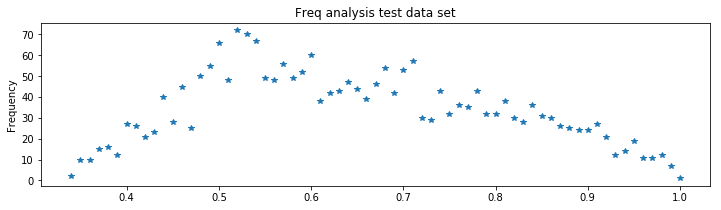

In [0]:
CountFrequency(freq_prob)

Text(0.5, 0, 'label confidence by the model')

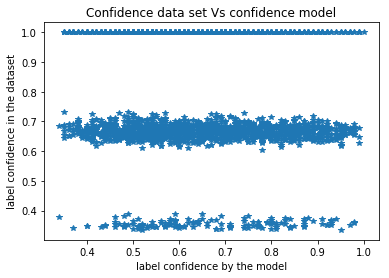

In [0]:
prob=analysis_pd['prob'].tolist()
conf=analysis_pd['sent_conf'].tolist()
plt.plot(prob, conf, '*')
plt.title('Confidence data set Vs confidence model')
plt.ylabel('label confidence in the dataset')
plt.xlabel('label confidence by the model')

